## Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from viz_preprocess import *
from viz_sequence import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


## Prepare Reference Alleles

In [2]:
cluster = '24'
fold = '6'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/gwas.pos.bed', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_ref = gwas_bed[4].tolist()
gwas_alt = gwas_bed[5].tolist()

ref_fasta = '/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/ref.pos.fasta'
ref_hyp_file = '/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/explain/output/ref_hyp_scores.txt'

ref_seqs = [x.rstrip() for (i,x) in enumerate(open(ref_fasta)) if i%2==1]
ref_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in ref_seqs if ('N' not in x)]

print("Num onehot sequences:", len(ref_onehot))

ref_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(ref_hyp_file)], ref_seqs) if 'N' not in w[1]]

ref_imp_scores = get_impscores(ref_hyp_scores, ref_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(ref_imp_scores,
                                 ref_onehot,
                                 ref_hyp_scores)])) == 0

ref_normed_imp_scores, ref_normed_hyp_scores = normalize_scores(
    impscores=ref_imp_scores, hyp_impscores=ref_hyp_scores, onehot_data=ref_onehot)

Num onehot sequences: 69


## Prepare Alternate Alleles

In [3]:
alt_fasta = '/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/alt.pos.fasta'
alt_hyp_file = '/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/explain/output/alt_hyp_scores.txt'
                                                                                
alt_seqs = [x.rstrip() for (i,x) in enumerate(open(alt_fasta)) if i%2==1]       
alt_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in alt_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(alt_onehot))                                 
                                                                                
alt_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(alt_hyp_file)], alt_seqs) if 'N' not in w[1]]                 
                                                                                
alt_imp_scores = get_impscores(alt_hyp_scores, alt_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(alt_imp_scores,                                
                                 alt_onehot,                                    
                                 alt_hyp_scores)])) == 0                        
                                                                                
alt_normed_imp_scores, alt_normed_hyp_scores = normalize_scores(                
    impscores=alt_imp_scores, hyp_impscores=alt_hyp_scores, onehot_data=alt_onehot)

Num onehot sequences: 69


## Find Alternate Alleles that Break Accessibility

In [4]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'ref_score':[], 'alt_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['ref_score'].append(np.sum(ref_imp_scores[i][400:600]))
    seq_dict['alt_score'].append(np.sum(alt_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(alt_imp_scores[i][400:600]) - np.sum(ref_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head()

,index,chr,start,end,ref_score,alt_score,delta
56,56,chr14,92932484,92932485,0.802390,0.182551,-0.619840
53,53,chr14,92932574,92932575,1.874449,1.465433,-0.409017
42,42,chr14,92934314,92934315,1.535171,1.142269,-0.392902
6,6,chr14,92935769,92935770,-0.720938,-1.000398,-0.279460
45,45,chr14,92931580,92931581,-1.145961,-1.420224,-0.274263


In [5]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(ref_seq.fetch(gwas_chrom[idx], gwas_end[idx] - 10, gwas_end[idx] + 10))

gctgtgtgagcttggacaag
CTCAGCAAGCGGAAGTTAAC
cagatgagagaggaagcagt
gagaatggcatgaacccggg
tgggtgggccgggacagtta


## Visualize Top Sequences

Index:  56  Importance:  0.8023902944699999  RSID:  rs4904923   chr14 : 92932484 - 92932485
Reference Allele:  G


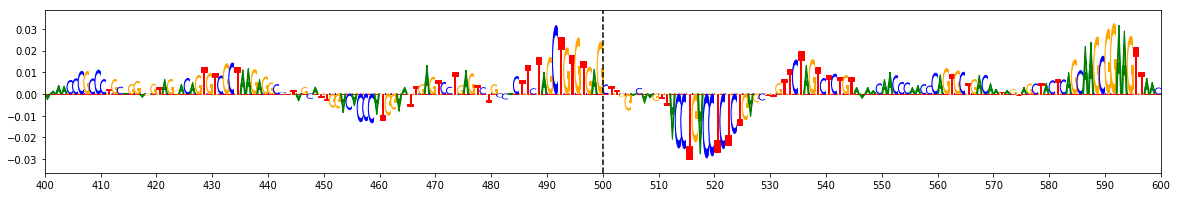

Index:  56  Importance:  0.18255063197999993  RSID:  rs4904923
Alternate Allele:  C


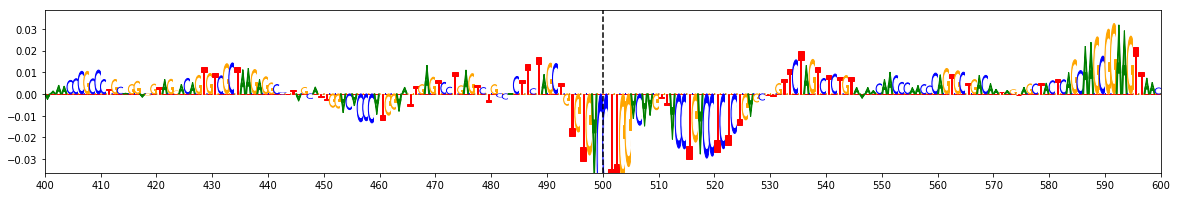

Index:  56  Delta:  -0.61983966249  RSID:  rs4904923
Alt - Ref:  C - G


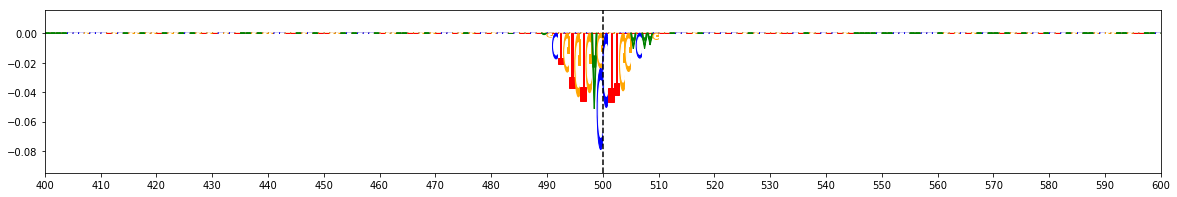

Index:  53  Importance:  1.8744491639  RSID:  rs10130373   chr14 : 92932574 - 92932575
Reference Allele:  C


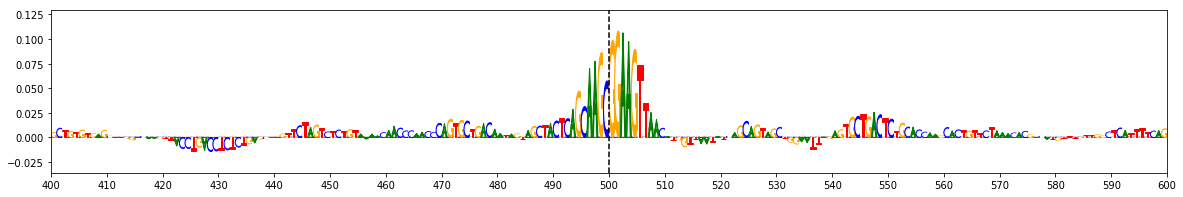

Index:  53  Importance:  1.465432523  RSID:  rs10130373
Alternate Allele:  T


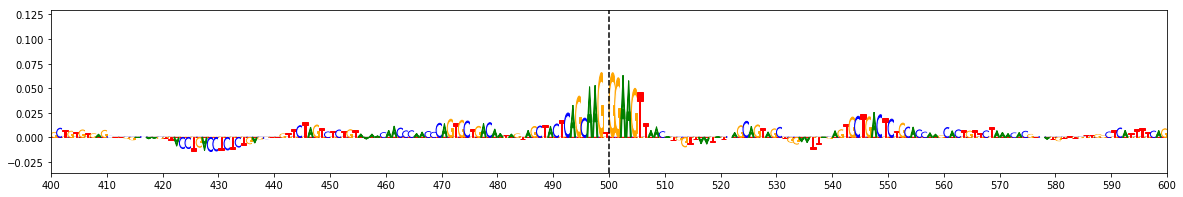

Index:  53  Delta:  -0.4090166409  RSID:  rs10130373
Alt - Ref:  T - C


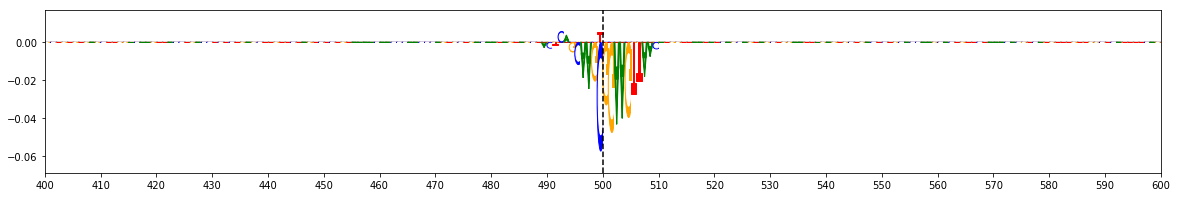

Index:  42  Importance:  1.5351710820000002  RSID:  rs7154400   chr14 : 92934314 - 92934315
Reference Allele:  G


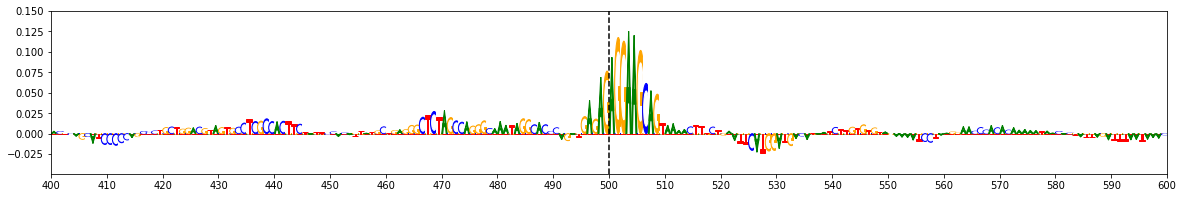

Index:  42  Importance:  1.1422693160000001  RSID:  rs7154400
Alternate Allele:  A


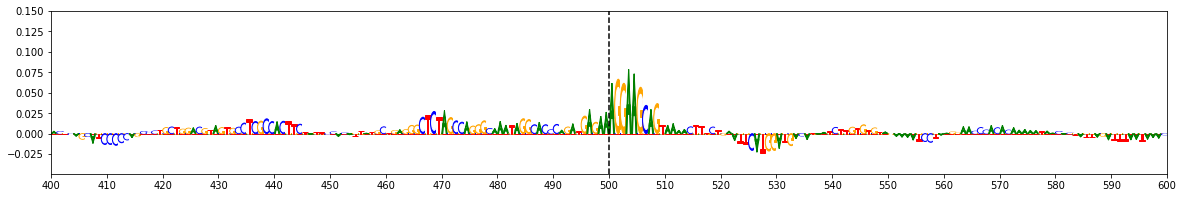

Index:  42  Delta:  -0.39290176600000004  RSID:  rs7154400
Alt - Ref:  A - G


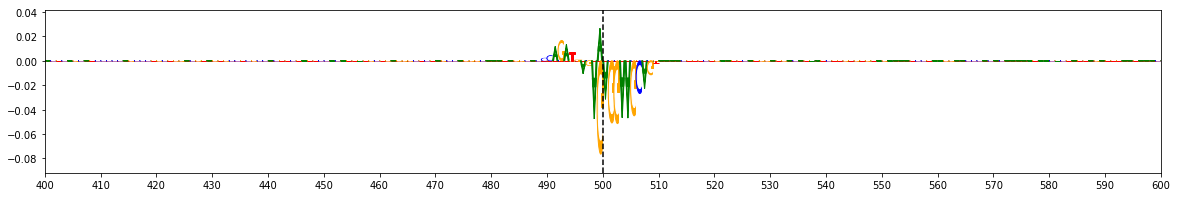

Index:  6  Importance:  -0.7209379490879999  RSID:  rs12897398   chr14 : 92935769 - 92935770
Reference Allele:  A


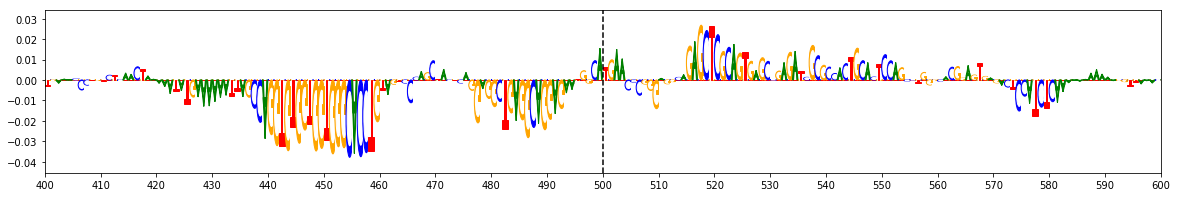

Index:  6  Importance:  -1.0003983365620002  RSID:  rs12897398
Alternate Allele:  T


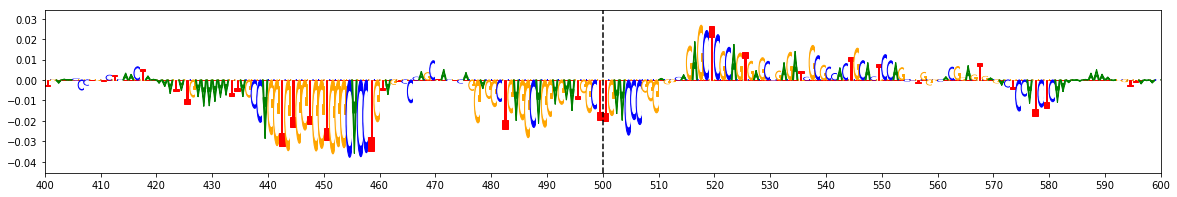

Index:  6  Delta:  -0.27946038747400026  RSID:  rs12897398
Alt - Ref:  T - A


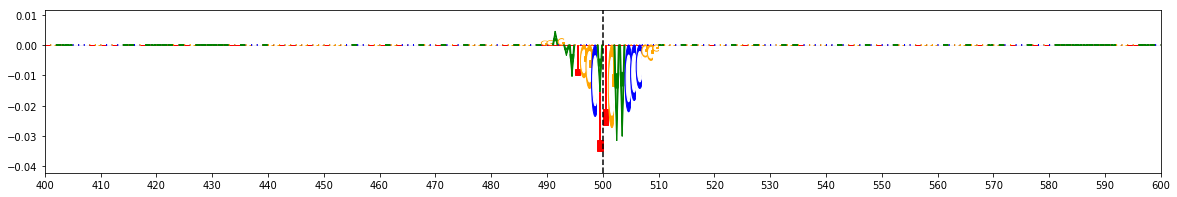

Index:  45  Importance:  -1.1459608178  RSID:  rs941649   chr14 : 92931580 - 92931581
Reference Allele:  C


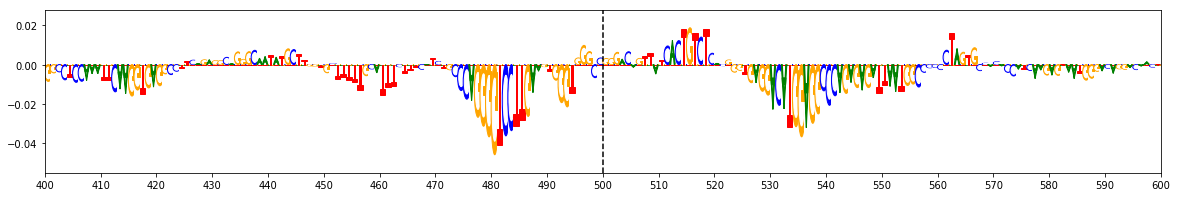

Index:  45  Importance:  -1.4202235898  RSID:  rs941649
Alternate Allele:  A


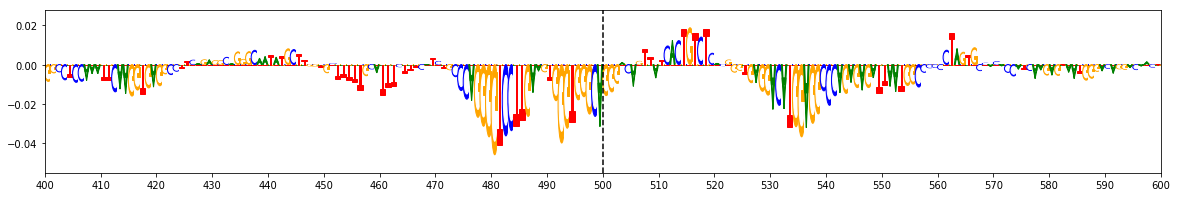

Index:  45  Delta:  -0.27426277199999993  RSID:  rs941649
Alt - Ref:  A - C


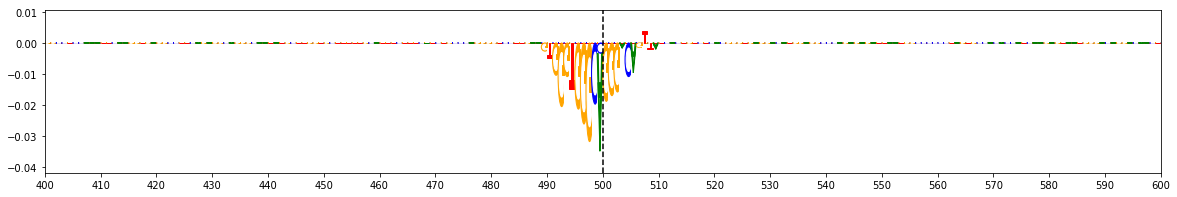

In [5]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    print("Reference Allele: ", gwas_ref[idx])
    ylim = plot_weights(ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'alt_score'], " RSID: ", gwas_rsid[idx])
    print("Alternate Allele: ", gwas_alt[idx])
    a = plot_weights(alt_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Alt - Ref: ", gwas_alt[idx] + ' - ' + gwas_ref[idx])
    a = plot_weights(alt_imp_scores[idx] - ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [6]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head()

,index,chr,start,end,ref_score,alt_score,delta
51,51,chr14,92932574,92932575,1.874449,2.728666,0.854217
65,65,chr14,92932101,92932102,-0.296807,0.083138,0.379944
10,10,chr7,50311098,50311099,-0.225357,0.123368,0.348725
52,52,chr14,92932574,92932575,1.874449,2.146958,0.272509
47,47,chr14,92932850,92932851,-0.248391,-0.038097,0.210294


## Visualize Top Sequences

Index:  51  Importance:  1.8744491639  RSID:  rs10130373 chr14 :  92932574  -  92932575
Alternate Allele:  A


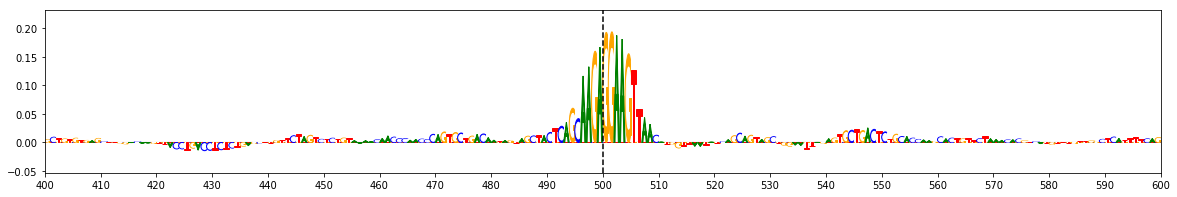

Index:  51  Importance:  1.8744491639  RSID:  rs10130373
Reference Allele:  C


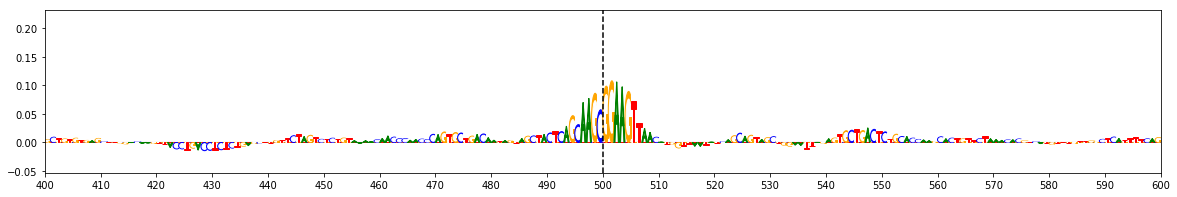

Index:  51  Delta:  0.8542168653000002  RSID:  rs10130373
Alt - Ref:  A - C


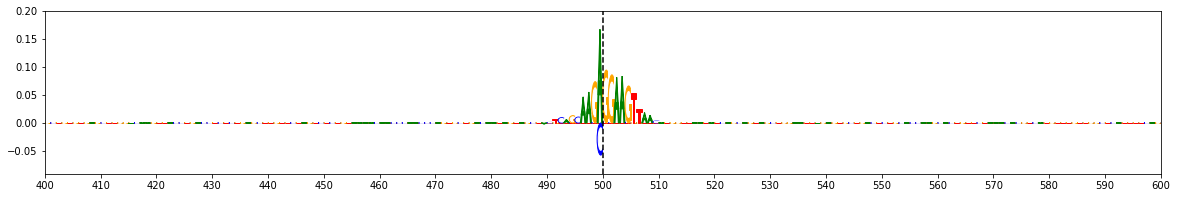

Index:  65  Importance:  -0.2968068649  RSID:  rs386780030 chr14 :  92932101  -  92932102
Alternate Allele:  CTCA


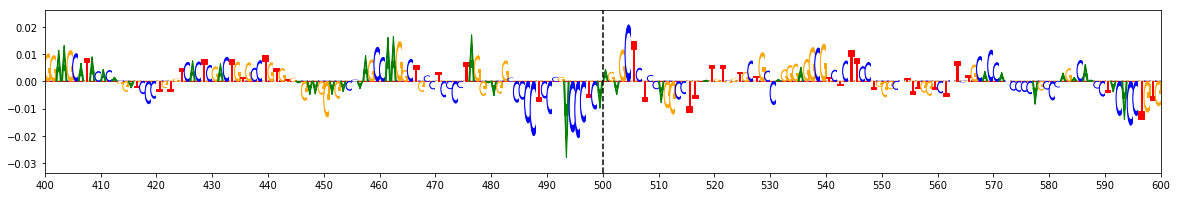

Index:  65  Importance:  -0.2968068649  RSID:  rs386780030
Reference Allele:  CCCG


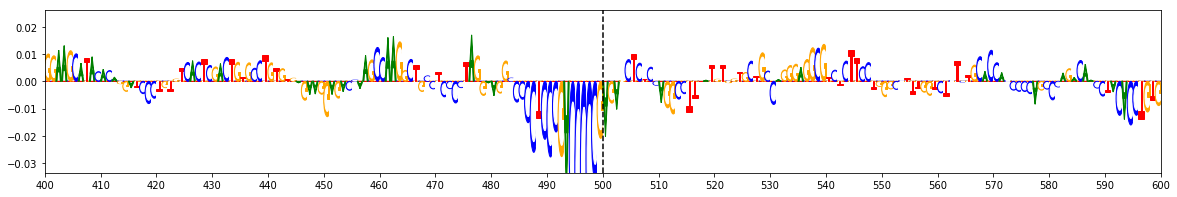

Index:  65  Delta:  0.37994438900000005  RSID:  rs386780030
Alt - Ref:  CTCA - CCCG


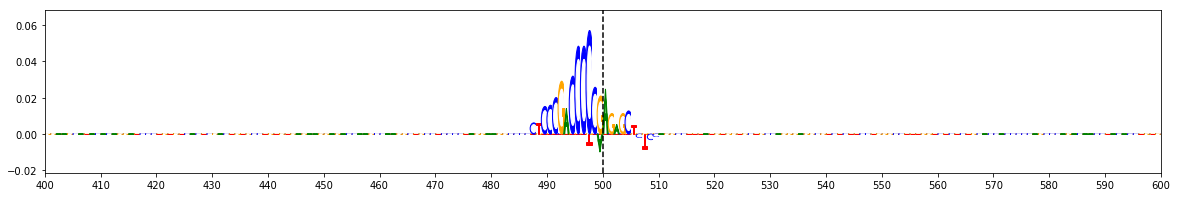

Index:  10  Importance:  -0.22535745609999996  RSID:  rs921913 chr7 :  50311098  -  50311099
Alternate Allele:  C


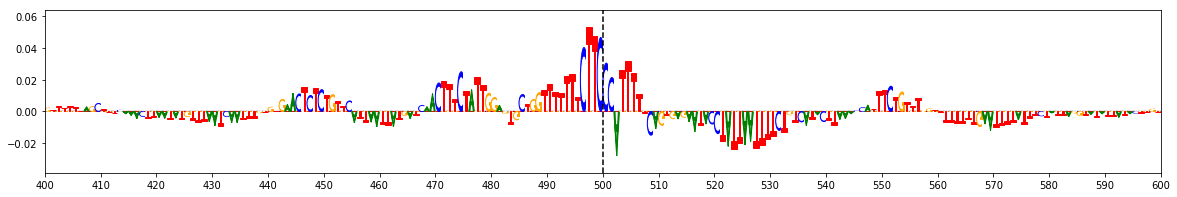

Index:  10  Importance:  -0.22535745609999996  RSID:  rs921913
Reference Allele:  G


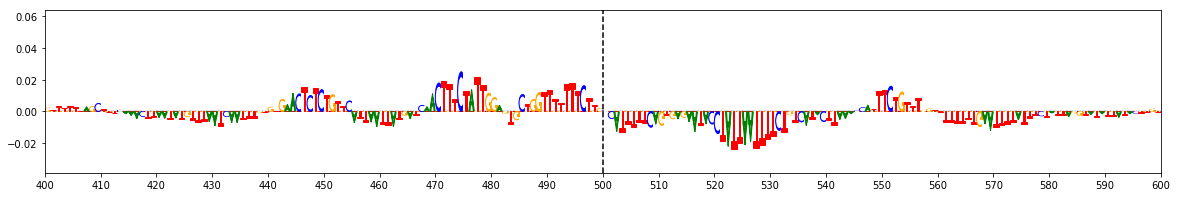

Index:  10  Delta:  0.34872547760000006  RSID:  rs921913
Alt - Ref:  C - G


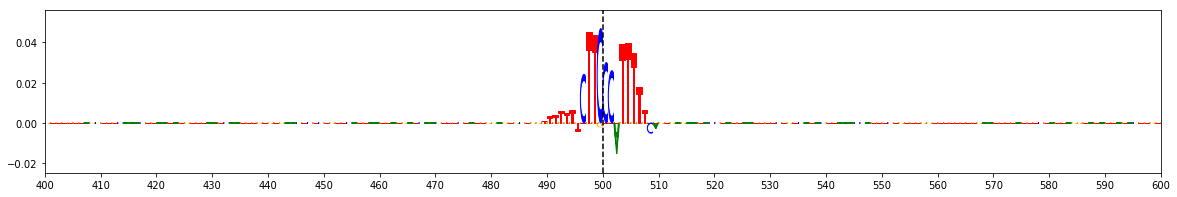

Index:  52  Importance:  1.8744491639  RSID:  rs10130373 chr14 :  92932574  -  92932575
Alternate Allele:  G


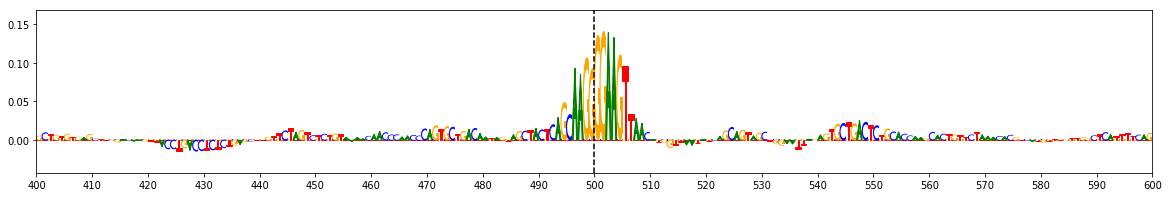

Index:  52  Importance:  1.8744491639  RSID:  rs10130373
Reference Allele:  C


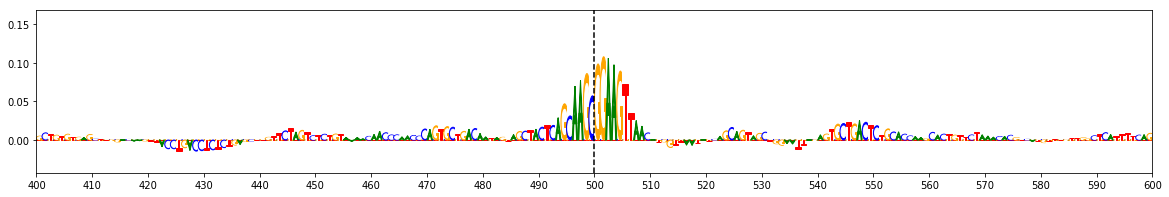

Index:  52  Delta:  0.2725085058000003  RSID:  rs10130373
Alt - Ref:  G - C


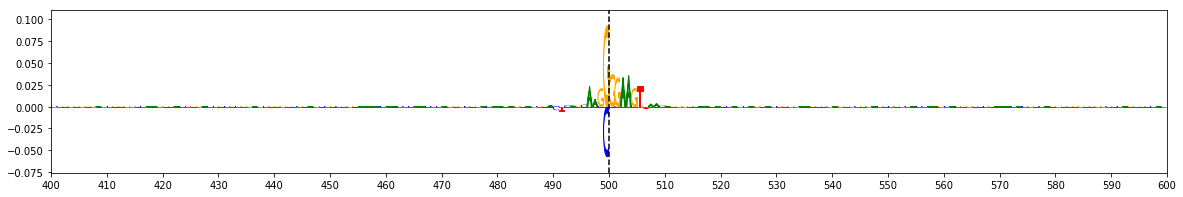

Index:  47  Importance:  -0.24839113620000003  RSID:  rs12880508 chr14 :  92932850  -  92932851
Alternate Allele:  T


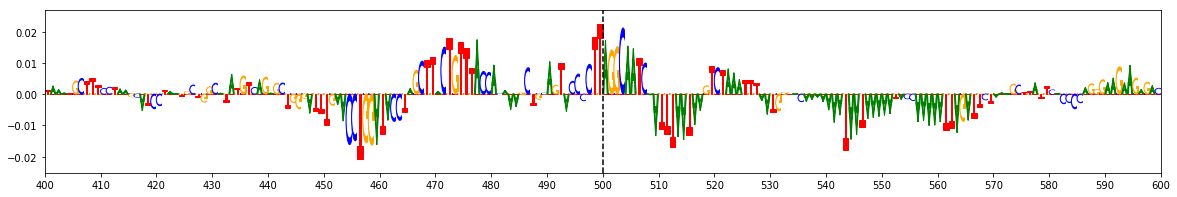

Index:  47  Importance:  -0.24839113620000003  RSID:  rs12880508
Reference Allele:  C


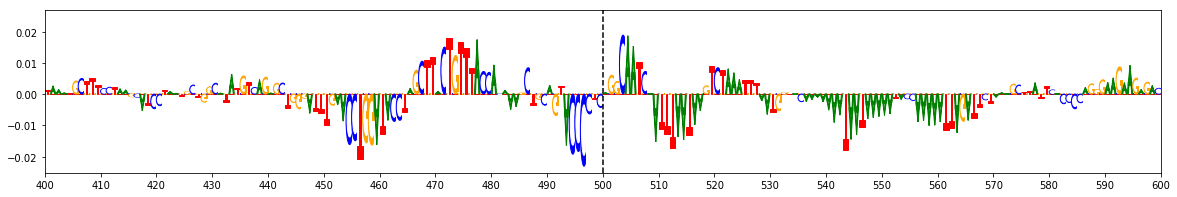

Index:  47  Delta:  0.2102944625  RSID:  rs12880508
Alt - Ref:  T - C


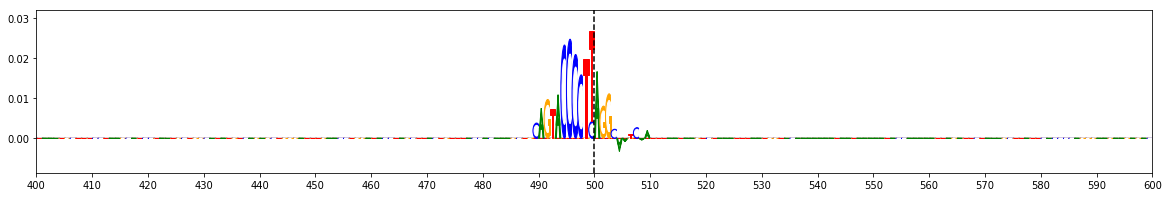

In [7]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'])
    print("Alternate Allele: ", gwas_alt[idx])
    ylim = plot_weights(alt_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx])
    print("Reference Allele: ", gwas_ref[idx])
    a = plot_weights(ref_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Alt - Ref: ", gwas_alt[idx] + ' - ' + gwas_ref[idx])
    a = plot_weights(alt_imp_scores[idx] - ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))